# Data preperation

### Extracting prospectuses summary

In [1]:
import pandas as pd
import re

# Replace path file
df = pd.read_csv("/Users/annabartyzel/Desktop/COMP0257 Project/Raw data/prospectuses.csv")
stock_performance_df = pd.read_csv("/Users/annabartyzel/Desktop/COMP0257 Project/Raw data/stock_performance.csv")

# Function to extract the summary from the ProspectusText
def extract_summary(text):
    try:
        match = re.search(r"This summary highlights(.*?)involves a high degree of risk", text, re.DOTALL)
        if match:
            return match.group(0)
        else:
            return "" 
    except Exception as e:
        return ""  

# Apply the function to the ProspectusText column
df['ProspectusSummary'] = df['ProspectusText'].apply(extract_summary)

df.to_csv("prospectuses_summaries.csv", index=False)

### Data cleaning

Filtering data

In [3]:
prospectuses_df = pd.read_csv("prospectuses_summaries.csv")

# Normalize Tickers
prospectuses_df['Ticker'] = prospectuses_df['Ticker'].str.strip().str.upper()
stock_performance_df['Ticker'] = stock_performance_df['Ticker'].str.strip().str.upper()

# Filter rows with missing ProspectusSummary
prospectuses_df = prospectuses_df[
    prospectuses_df['ProspectusSummary'].notna() & 
    (prospectuses_df['ProspectusSummary'].str.strip() != "")
]

# Filter prospectuses for only companies with available stock performance data
valid_tickers = set(stock_performance_df['Ticker'])
filtered_prospectuses_df = prospectuses_df[prospectuses_df['Ticker'].isin(valid_tickers)]

filtered_prospectuses_df.to_csv("filtered_prospectuses.csv", index=False)

Cleaning data 

In [4]:
df = pd.read_csv("filtered_prospectuses.csv")

# Preprocessing function
def preprocess_prospectuses(text):
    text = re.sub(r'https://www\.sec\.gov/\S+', '', text)  # Remove SEC links
    text = re.sub(r'\btable of contents\b', '', text, flags=re.IGNORECASE)  # Remove "Table of Contents"
    text = re.sub(r'\b\d{2}:\d{2}\b', '', text)  # Remove time stamps
    text = re.sub(r'\b26/12/2024\b', '', text)  # Remove date stamp "26/12/2024"
    text = re.sub(r'\b\d+/\d+\b', '', text)  # Remove page numbers as fractions
    return text 
    
# Apply preprocessing to the ProspectusText column
df["ProcessedSummary"] = df["ProspectusSummary"].apply(preprocess_prospectuses)

df.to_csv("preprocessed_prospectuses.csv", index=False)

# Preprocessing

### Tokenizing and chunking

In [5]:
from transformers import BertTokenizer

df = pd.read_csv("preprocessed_prospectuses.csv")

tokenizer = BertTokenizer.from_pretrained("bert-base-cased") # Cased version, in consideration for names e.g. Apple vs apple etc.

# Function to tokenize and chunk 
def tokenize_and_chunk(text, max_length=510, overlap=50):
    tokens = tokenizer.tokenize(text)  # Tokenize the full text using WordPiece tokenizer
    chunks = []
    start = 0

    while start < len(tokens):
        # Chunking 
        end = start + max_length
        chunk_tokens = tokens[start:start + max_length -2]  # Leave space for [CLS] and [SEP] tokens

        # Manually add special tokens
        chunk_tokens = [tokenizer.cls_token] + chunk_tokens + [tokenizer.sep_token]

        # Convert tokens to input IDs
        input_ids = tokenizer.convert_tokens_to_ids(chunk_tokens)

        # Create attention mask
        attention_mask = [1] * len(input_ids)

        # Ensure consistent padding to 512 tokens
        padding_length = 512 - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length

        # Append the chunk
        chunks.append({
            "input_ids": input_ids,
            "attention_mask": attention_mask
        })

        # Move to the next chunk with overlap
        start += max_length - overlap

    return chunks

# Apply tokenization and chunking to the ProcessedSummary column
df["BERT_Chunks"] = df["ProcessedSummary"].apply(tokenize_and_chunk)

df_exploded = df.explode("BERT_Chunks", ignore_index=True)

df_exploded.to_pickle("chunked_tokenized_summaries.pkl")

# Generating BERT embeddings

### BERT model

In [6]:
from transformers import BertModel
import torch

df_exploded = pd.read_pickle("chunked_tokenized_summaries.pkl")

# Load the pre-trained BERT model
model = BertModel.from_pretrained("bert-base-cased")
model.eval()  # Set model to evaluation mode

# Function to compute embeddings for a single chunk
def compute_embedding(chunk):

    # Extract input_ids and attention_mask from the chunk, and convert them into PyToch tensors with batch dimension
    input_ids = torch.tensor(chunk["input_ids"]).unsqueeze(0) 
    attention_mask = torch.tensor(chunk["attention_mask"]).unsqueeze(0) 
    
    # Generate embeddings
    with torch.no_grad():  # Disable gradient computation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Processes inputs through model's transformer layers
    
    # Extract the [CLS] token's embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0) 
    return cls_embedding.numpy()  # Convert to NumPy

# Apply embedding function to the BERT_Chunks column
df_exploded["BERT_Embedding"] = df_exploded["BERT_Chunks"].apply(compute_embedding)

df_exploded.to_pickle("prospectuses_embeddings.pkl")

### Average embeddings

In [7]:
import numpy as np

df_exploded = pd.read_pickle("prospectuses_embeddings.pkl")

# Compute the average embeddings for each Ticker
average_embeddings_df = (
    df_exploded.groupby("Ticker")["BERT_Embedding"]
    .apply(lambda embeddings: np.mean(np.stack(embeddings), axis=0)) 
    .reset_index() 
)

# Rename the BERT_Embedding column to AverageEmbedding
average_embeddings_df.rename(columns={"BERT_Embedding": "AverageEmbedding"}, inplace=True)

average_embeddings_df.to_pickle("prospectuses_average_embeddings.pkl")

### Stock performance data

In [9]:
average_embeddings_df = pd.read_pickle("prospectuses_average_embeddings.pkl")
stock_performance_df = pd.read_csv("/Users/annabartyzel/Desktop/COMP0257 Project/Raw data/stock_performance.csv")

# Merge stock performance data with average embeddings for each Ticker
stock_performance_df["Performance"] = stock_performance_df["Performance"].str.rstrip('%').astype(float) # Convert stock performance to numeric
merged_df = average_embeddings_df.merge(
    stock_performance_df, 
    on="Ticker", 
    how="left"
)

merged_df.to_pickle("merged_embeddings_performance.pkl")

# Correlation analysis

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

merged_df = pd.read_pickle("merged_embeddings_performance.pkl")

# Extract embeddings
embeddings = np.vstack(merged_df['AverageEmbedding'])

# Apply PCA dimensionality reduction to embeddings
pca = PCA()
pca_components = pca.fit_transform(embeddings)

# Compute Pearson correlations between embeddings and stock performance
correlations = pd.Series(
    [np.corrcoef(pca_components[:, i], merged_df["Performance"])[0, 1] for i in range(pca_components.shape[1])],
    index=[f"PC{i+1}" for i in range(pca_components.shape[1])]
)

# Create a correlation DataFrame
correlation_df = pd.DataFrame({
    "PCA Component": correlations.index,
    "Correlation": correlations.values
})

correlation_df.to_pickle("pca_correlation_results.pkl")

In [19]:
average_correlation = correlations.mean()
average_absolute_correlation = correlations.abs().mean()
variance_correlation = correlations.var()
std_dev_correlation = correlations.std()
max_correlation = correlations.max()
min_correlation = correlations.min()

print(f"Average Correlation: {average_correlation}")
print(f"Average Absolute Correlation: {average_absolute_correlation}")
print(f"Variance of Correlations: {variance_correlation}")
print(f"Standard Deviation of Correlations: {std_dev_correlation}")
print(f"Maximum Correlation: {max_correlation}")
print(f"Minimum Correlation: {min_correlation}")

Average Correlation: 0.019338049953109858
Average Absolute Correlation: 0.07922662173115516
Variance of Correlations: 0.009340569938180545
Standard Deviation of Correlations: 0.09664662403923142
Maximum Correlation: 0.2366564701549041
Minimum Correlation: -0.2500215027738665


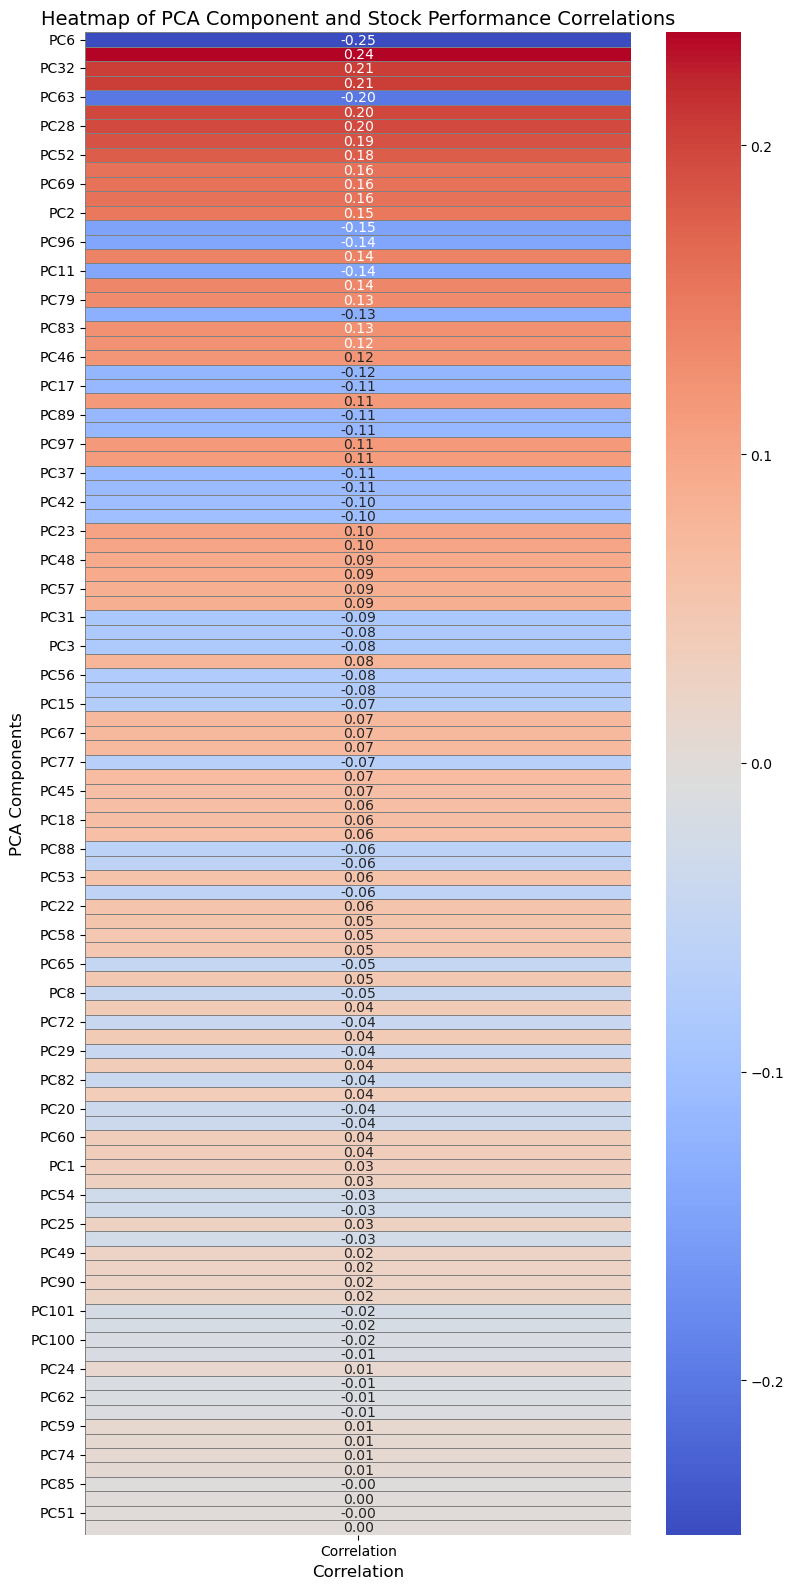

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_correlations = correlation_df.reindex(
    correlation_df["Correlation"].abs().sort_values(ascending=False).index
)
heatmap_data = sorted_correlations.set_index("PCA Component")["Correlation"].to_frame()

# Heatmap plot
plt.figure(figsize=(8, 16))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)

# Custom
plt.title("Heatmap of PCA Component and Stock Performance Correlations", fontsize=14)
plt.xlabel("Correlation", fontsize=12)
plt.ylabel("PCA Components", fontsize=12)
plt.tight_layout()

plt.show()

# Latent space visualization

/Users/annabartyzel/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


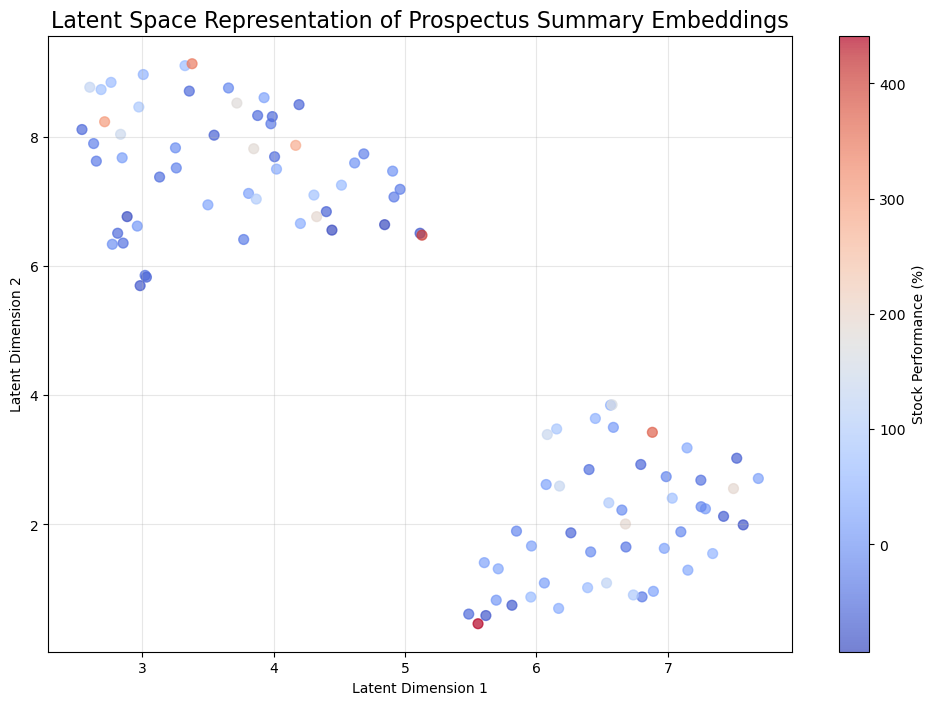

In [18]:
import umap

merged_df = pd.read_pickle("merged_embeddings_performance.pkl")

# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
latent_space = reducer.fit_transform(embeddings)

# Add latent space coordinates
merged_df["Latent_X"] = latent_space[:, 0]
merged_df["Latent_Y"] = latent_space[:, 1]

# Plot the latent space with stock performance coloring
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df["Latent_X"],
    merged_df["Latent_Y"],
    c=merged_df["Performance"],
    cmap="coolwarm",
    s=50,
    alpha=0.7
)

# Color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label("Stock Performance (%)")

# Custom
plt.title("Latent Space Representation of Prospectus Summary Embeddings", fontsize=16)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(alpha=0.3)

plt.show()